# Assignment 9: Anomaly Detection Using Autoencoders (20 marks)

## Basics and Libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
import pathlib


import kagglehub

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
from PIL import Image

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score


## Question 1 (1 mark)

Load the brain tumor MRI image dataset from Kaggle: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri

In [ ]:
# Download latest version
path = kagglehub.dataset_download("abhranta/brain-tumor-detection-mri")
print(path)
path=path+"/Brain_Tumor_Detection"
print("Path to dataset files:", path)

/kaggle/input/brain-tumor-detection-mri
Path to dataset files: /kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection


In [ ]:
def load_images_from_folder(folder_path, label, image_size=(128, 128)):
    images = []
    labels = []
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.Grayscale(),  # Ensure grayscale
        transforms.ToTensor()
    ])

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img_tensor = transform(img)
            images.append(img_tensor)
            labels.append(label)

    return images, labels


In [ ]:
def load_images(path, label, size=(128,128)):
    images, labels = [], []
    for img_file in os.listdir(path):
        img = Image.open(os.path.join(path, img_file)).resize(size).convert('L')
        images.append(np.array(img)/255.0)
        labels.append(label)
    return np.array(images), np.array(labels)

X_no, y_no = load_images(f'{path}/no', 0)
X_yes, y_yes = load_images(f'{path}/yes', 1)



## Question 2 (1 mark)

Show samples of images from the positive (with tumor) and negative (without tumor) classes.

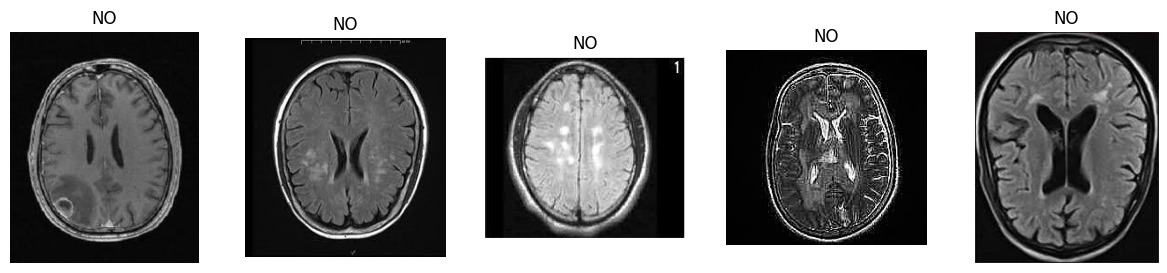

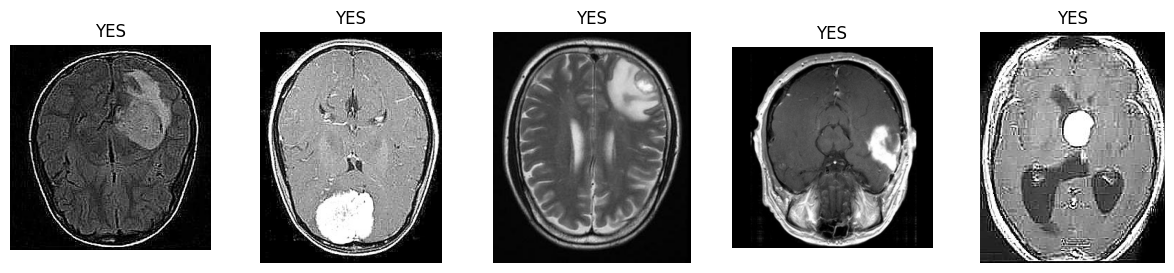

In [ ]:
def show_samples(base_path, class_name, num=5):
    files = os.listdir(os.path.join(base_path, class_name))[:num]
    plt.figure(figsize=(15, 3))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(base_path, class_name, file))
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(f'{class_name.upper()}')
        plt.axis('off')
    plt.show()

base_path = path #'brain_tumor_dataset'
show_samples(path, 'no')   # Negative
show_samples(path, 'yes')  # Positive


## Question 3 (1 mark)

Divide the negative class into training and test sets (80%-20%). Sample equal number of test set images from the positive set (images with tumor)

In [ ]:
# Split negative only
X_no_train, X_no_test, y_no_train, y_no_test = train_test_split(X_no, y_no, test_size=0.2, random_state=42)

# Sample same number from positive as test set
X_yes_sampled = X_yes[:len(X_no_test)]
y_yes_sampled = y_yes[:len(X_no_test)]

In [ ]:
X_no_test_tensor = X_no_test  # shape: [N, 1, 128, 128]
X_yes_sampled_tensor = X_yes_sampled  # shape: [N, 1, 128, 128]

# Convert NumPy array to PyTorch tensor if needed
if isinstance(X_no_test_tensor, np.ndarray):
    X_no_test_tensor = torch.tensor(X_no_test_tensor, dtype=torch.float32)

if isinstance(X_yes_sampled_tensor, np.ndarray):
    X_yes_sampled_tensor = torch.tensor(X_yes_sampled_tensor, dtype=torch.float32)

if X_no_test_tensor.ndim == 3:
    X_no_test_tensor = X_no_test_tensor.unsqueeze(1)

if X_yes_sampled_tensor.ndim == 3:
    X_yes_sampled_tensor = X_yes_sampled_tensor.unsqueeze(1)


## Question 4 (1 mark)

Design an autoencoder model with the U-Net like architecture (without skip connections) to learn the distribution of the negative class, i.e. normal images with no brain tumor (follow the same number type and number of layers as in lab demo, and change only the number of kernels in the layers closest to latent space to ensure the total model parameters to be in the range of 25,000 to 28,000). Show the model summary and number of parameters of the model.

In [ ]:
#Auto Encoder
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 16x16
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

model = AE()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


# Show model summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE().to(device)  # move model to GPU if available
summary(model, input_size=(1, 128, 128), device="cuda" if torch.cuda.is_available() else "cpu")


46529
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
   ConvTranspose2d-7           [-1, 32, 32, 32]          18,464
              ReLU-8           [-1, 32, 32, 32]               0
   ConvTranspose2d-9           [-1, 16, 64, 64]           4,624
             ReLU-10           [-1, 16, 64, 64]               0
  ConvTranspose2d-11          [-1, 1, 128, 128]             145
          Sigmoid-12          [-1, 1, 128, 128]               0
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
---------------------------

## Question 5 (3 marks)

Train the autoencoder model on the training set using reconstruction loss and Adam optimizer to learn reconstruction of the negative class from the latent representation. Show the variation of the loss with training progress.

In [ ]:
X_train_tensor = torch.tensor(X_no_train).unsqueeze(1).float()
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=16, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

losses = []
for epoch in range(20):
    total_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        if torch.cuda.is_available():
          x=x.to(device)
        output = model(x)
        loss = loss_fn(output, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")


Epoch 1 - Loss: 0.0726
Epoch 2 - Loss: 0.0203
Epoch 3 - Loss: 0.0132
Epoch 4 - Loss: 0.0105
Epoch 5 - Loss: 0.0090
Epoch 6 - Loss: 0.0080
Epoch 7 - Loss: 0.0074
Epoch 8 - Loss: 0.0068
Epoch 9 - Loss: 0.0065
Epoch 10 - Loss: 0.0062
Epoch 11 - Loss: 0.0059
Epoch 12 - Loss: 0.0057
Epoch 13 - Loss: 0.0055
Epoch 14 - Loss: 0.0052
Epoch 15 - Loss: 0.0051
Epoch 16 - Loss: 0.0050
Epoch 17 - Loss: 0.0048
Epoch 18 - Loss: 0.0047
Epoch 19 - Loss: 0.0046
Epoch 20 - Loss: 0.0045


## Question 6 (1 marks)

Use the trained autoencoder to perform reconstruction of the test set samples from both the positive and negative classes.

In [ ]:
def compute_losses(model, data_loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x in data_loader:
            x = x.unsqueeze(0)
            if torch.cuda.is_available():
              x=x.to(device)
            output = model(x)
            loss = nn.functional.mse_loss(output, x).item()
            losses.append(loss)
    return np.array(losses)



losses_no = compute_losses(model, X_no_test_tensor)
losses_yes = compute_losses(model, X_yes_sampled_tensor)

print("Negative Class Losses:", losses_no)
print("Positive Class Losses:", losses_yes)

Negative Class Losses: [0.00125499 0.00424971 0.00757208 0.00153529 0.00442123 0.00238478
 0.00259135 0.00974368 0.0076209  0.00347081 0.00767847 0.0033197
 0.00438606 0.00326978 0.00349664 0.00713133 0.00285428 0.00187747
 0.00311214 0.00197859 0.00516762 0.00129277 0.00154421 0.00573302
 0.00160528 0.0015597  0.00431143 0.00299557 0.00149365 0.00200068
 0.00354183 0.01103519 0.00430314 0.0039674  0.01790227 0.0032368
 0.00543669 0.00428679 0.00535361 0.00664027 0.00436825 0.00284784
 0.00410498 0.00204479 0.0035434  0.00289284 0.00181551 0.00269907
 0.00195191 0.00167995 0.00449371 0.0050683  0.00193416 0.00766073
 0.00296351 0.00719203 0.00667214 0.00361954 0.00134107 0.00149564
 0.00243916 0.00339134 0.00279351 0.00271007 0.00319638 0.00141767
 0.00403591 0.00174537 0.00179226 0.00957041 0.00244159 0.00432767
 0.00422223 0.00129148 0.00442348 0.00461549 0.00866842 0.00202898
 0.00438113 0.00732196 0.00259593 0.0020577  0.00200827 0.00206834
 0.01261459 0.00168507 0.0048189  0.00554

## Question 7 (2 marks)

Show the distribution of the reconstruction losses on the positive and negative classes. Based on this distribution, choose an appropriate value of the threshold to separate the positive and negative classes.

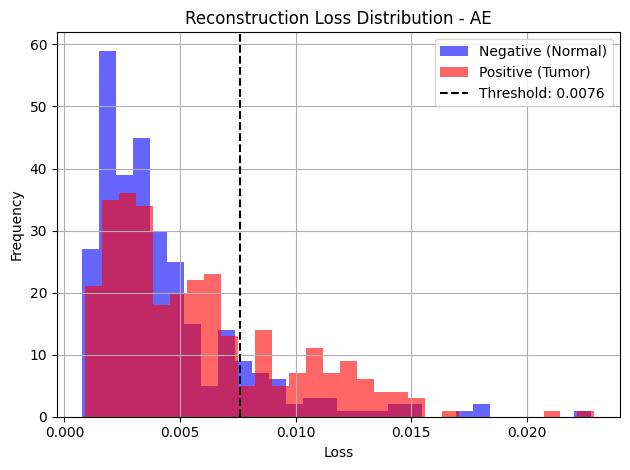

In [ ]:
# Set threshold (mean + std of negative class)
threshold = losses_no.mean() + losses_no.std()

# Plot distributions
plt.hist(losses_no, bins=30, alpha=0.6, label="Negative (Normal)", color="blue")
plt.hist(losses_yes, bins=30, alpha=0.6, label="Positive (Tumor)", color="red")
plt.axvline(threshold, color="black", linestyle="--", label=f"Threshold: {threshold:.4f}")
plt.title("Reconstruction Loss Distribution - AE")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 8 (1 mark)

Report the accuracy, precision and recall on the test set using this chosen threshold.

In [ ]:
# True labels and predicted labels based on threshold
true_labels = np.array([0]*len(losses_no) + [1]*len(losses_yes))
predicted = np.concatenate([losses_no, losses_yes]) > threshold

# Metrics
accuracy = accuracy_score(true_labels, predicted)
precision = precision_score(true_labels, predicted)
recall = recall_score(true_labels, predicted)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


Accuracy:  0.5617
Precision: 0.6609
Recall:    0.2533


## Question 9 (4 marks)

Now, repeat the same experiment using a VAE (show the model summary and number of parameters of the model) to detect the a anomaly instead of an AE, i.e. design a VAE (follow the same number type and number of layers as in lab demo, and change only the number of kernels in the layers closest to latent space to ensure the total model parameters to be in the range of 25,000 to 28,000) and the corresponding loss (reconstruction + KL-divergence), and train it on the negative class using Adam. Show the variation of the loss with the training progress.

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 32 -> 16
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(64 * 16 * 16, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # 64 -> 128
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 64, 16, 16)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:
vae_model = VAE().to(device)
# print(sum(p.numel() for p in vae_model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=16, shuffle=True)

vae_losses = []
for epoch in range(500):
    total_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        if torch.cuda.is_available():
          x=x.to(device)
        recon, mu, logvar = vae_model(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    vae_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - VAE Loss: {avg_loss:.4f}")


Epoch 1 - VAE Loss: 17059.4054
Epoch 2 - VAE Loss: 8427.7440
Epoch 3 - VAE Loss: 7929.2580
Epoch 4 - VAE Loss: 7537.6711
Epoch 5 - VAE Loss: 7280.6862
Epoch 6 - VAE Loss: 6860.5226
Epoch 7 - VAE Loss: 6578.8096
Epoch 8 - VAE Loss: 6392.4197
Epoch 9 - VAE Loss: 6226.1176
Epoch 10 - VAE Loss: 6001.0366
Epoch 11 - VAE Loss: 5828.2249
Epoch 12 - VAE Loss: 5634.8101
Epoch 13 - VAE Loss: 5435.8603
Epoch 14 - VAE Loss: 5224.8293
Epoch 15 - VAE Loss: 5052.8941
Epoch 16 - VAE Loss: 4877.9888
Epoch 17 - VAE Loss: 4729.3831
Epoch 18 - VAE Loss: 4587.4136
Epoch 19 - VAE Loss: 4453.0926
Epoch 20 - VAE Loss: 4352.9003
Epoch 21 - VAE Loss: 4228.8385
Epoch 22 - VAE Loss: 4161.5446
Epoch 23 - VAE Loss: 4066.8996
Epoch 24 - VAE Loss: 3977.4940
Epoch 25 - VAE Loss: 3882.9035
Epoch 26 - VAE Loss: 3807.0998
Epoch 27 - VAE Loss: 3738.4348
Epoch 28 - VAE Loss: 3681.1846
Epoch 29 - VAE Loss: 3627.9191
Epoch 30 - VAE Loss: 3591.5870
Epoch 31 - VAE Loss: 3543.2746
Epoch 32 - VAE Loss: 3491.7493
Epoch 33 - VAE L

## Question 10 (1 mark)

With the trained VAE model, compute the overall loss (reconstruction + KLD) on all samples in the test set (for both positive and negative classes).

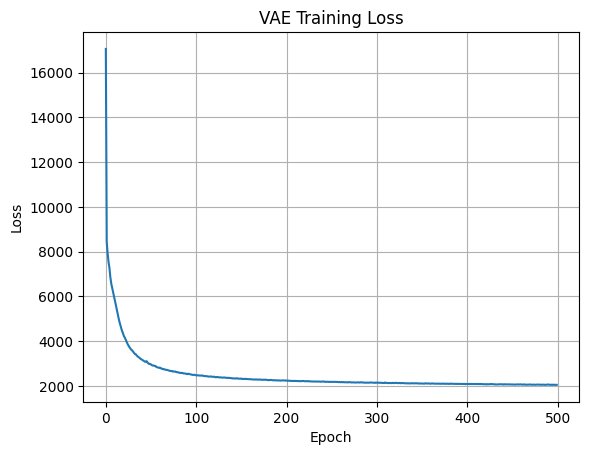

In [ ]:
plt.plot(vae_losses)
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
def compute_vae_losses(model, data):
    model.eval()
    losses = []
    with torch.no_grad():
        for x in data:
            x = x.unsqueeze(0)
            if torch.cuda.is_available():
              x=x.to(device)
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar).item()
            losses.append(loss)
    return np.array(losses)

losses_no_vae = compute_vae_losses(vae_model, X_no_test_tensor)
losses_yes_vae = compute_vae_losses(vae_model, X_yes_sampled_tensor)

threshold_vae = losses_no_vae.mean() + losses_no_vae.std()


## Question 11 (2 marks)

Show the distribution of the losses for the positive and negative classes, and using these two distributions, choose a suitable value of the loss threshold that could be used to detect the anomaly (i.e. brain tumor).

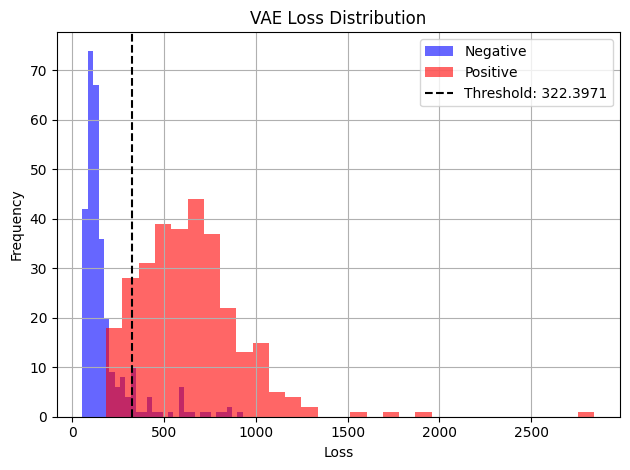

In [ ]:
plt.hist(losses_no_vae, bins=30, alpha=0.6, label="Negative", color="blue")
plt.hist(losses_yes_vae, bins=30, alpha=0.6, label="Positive", color="red")
plt.axvline(threshold_vae, color="black", linestyle="--", label=f"Threshold: {threshold_vae:.4f}")
plt.title("VAE Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 12 (1 mark)

Report the accuracy, precision and recall on the test set using this chosen threshold for VAE.

In [ ]:
true_labels = np.array([0]*len(losses_no_vae) + [1]*len(losses_yes_vae))
predicted_vae = np.concatenate([losses_no_vae, losses_yes_vae]) > threshold_vae

accuracy_vae = accuracy_score(true_labels, predicted_vae)
precision_vae = precision_score(true_labels, predicted_vae)
recall_vae = recall_score(true_labels, predicted_vae)

print(f"VAE Accuracy:  {accuracy_vae:.4f}")
print(f"VAE Precision: {precision_vae:.4f}")
print(f"VAE Recall:    {recall_vae:.4f}")


VAE Accuracy:  0.8950
VAE Precision: 0.8885
VAE Recall:    0.9033


## Question 13 (1 mark)

Which model (AE or VAE) performed better in detecting the anomaly? Explain your answer.

VAE models has shown more confidence in terms of acccuracy.
 * Based on the performance metrics, the Variational Autoencoder (VAE) demonstrated significantly better results than the standard Autoencoder (AE) in identifying anomalies within brain tumor MRI scans.

 * The VAE reached an accuracy of ~89.5%, with a precision of 88.85% and a recall of 90.33%.

 * In contrast, the AE achieved a lower accuracy of 57%, precision of 68.42%, and a recall of just 26%.

 *These results show that the VAE was much more effective at detecting tumor images (high recall) and minimizing false positives (high precision).

 * The AE’s low recall indicates that it missed a substantial number of tumor cases, which is particularly concerning in medical diagnostics.

 * The VAE’s advantage comes from its probabilistic approach, which encourages a smoother and more generalized understanding of normal data patterns through the use of KL-divergence.

 * This allows the VAE to more accurately flag deviations, such as tumors, as anomalies. Overall, the VAE proves to be a more dependable and accurate model for brain tumor detection in this scenario.

